In [1]:
import tensorflow as tf
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
import pickle

In [2]:
# Ще разгледаме нов dataset (cifar10)
# Нека за начало го обработим

cifar10_folder = "cifar-10-batches-py"
cifar10_train_files = [f"data_batch_{x}" for x in range(1, 6)]
cifar10_test_files = ["test_batch"]
cifar10_train_files

['data_batch_1',
 'data_batch_2',
 'data_batch_3',
 'data_batch_4',
 'data_batch_5']

In [3]:
cifar10 = {"train_x": [], "train_y" : [], "test_x" : [], "test_y" : []}

for file_name in cifar10_train_files:
    file = os.path.join(cifar10_folder, file_name)
    with open(file, 'rb') as fo:
        d = pickle.load(fo, encoding="bytes")
    cifar10["train_x"].append(d[b"data"])
    cifar10["train_y"].append(d[b"labels"])
    
for file_name in cifar10_test_files:
    file = os.path.join(cifar10_folder, file_name)
    with open(file, 'rb') as fo:
        d = pickle.load(fo, encoding="bytes")
    cifar10["test_x"].append(d[b"data"])
    cifar10["test_y"].append(d[b"labels"])
    
cifar10["train_x"] = np.concatenate(cifar10["train_x"])
cifar10["train_y"] = np.concatenate(cifar10["train_y"])
cifar10["test_x"] = np.concatenate(cifar10["test_x"])
cifar10["test_y"] = np.concatenate(cifar10["test_y"])

print(cifar10["train_x"].shape, cifar10["train_y"].shape, cifar10["test_x"].shape, cifar10["test_y"].shape)

(50000, 3072) (50000,) (10000, 3072) (10000,)


In [4]:
cifar10["train_x"] = np.transpose(cifar10["train_x"].reshape(-1, 3, 32, 32), (0, 2, 3, 1))/255.0
cifar10["test_x"] = np.transpose(cifar10["test_x"].reshape(-1, 3, 32, 32), (0, 2, 3, 1))/255.0

print(cifar10["train_x"].shape, cifar10["test_x"].shape)

(50000, 32, 32, 3) (10000, 32, 32, 3)


In [5]:
with open(os.path.join(cifar10_folder, "batches.meta"), 'rb') as fo:
    d = pickle.load(fo, encoding="bytes")
cifar10["label_names"] = d[b"label_names"]
cifar10["label_names"]

[b'airplane',
 b'automobile',
 b'bird',
 b'cat',
 b'deer',
 b'dog',
 b'frog',
 b'horse',
 b'ship',
 b'truck']

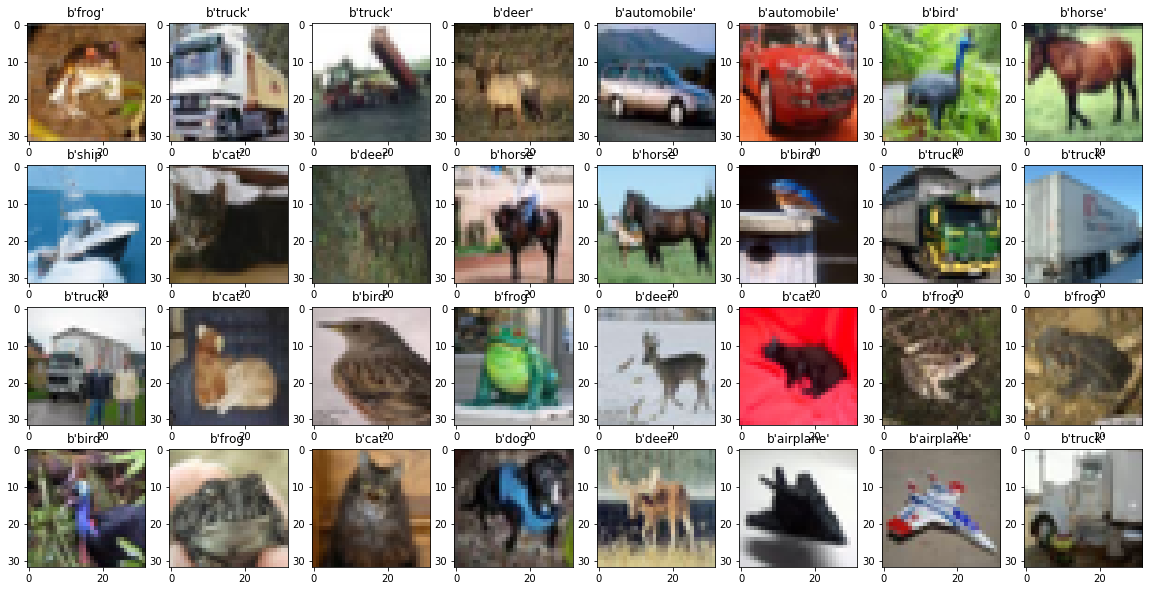

In [6]:
fig, axss = plt.subplots(4, 8, figsize=(20, 10))
for i in range(32):
    axss[i//8][i%8].set_title(cifar10["label_names"][cifar10["train_y"][i]])
    axss[i//8][i%8].imshow(cifar10["train_x"][i])
plt.show()

In [7]:
# Сега да кажем какво е конволюция в конволюционните мрежи
# За целта ще се върнем назад в историята на machine vision
# Да отговорим като за начало на следния лесен въпрос: Как да направим edge detection?

In [8]:
def zton(x):
    return x if x!=0 else None

def simpleConv2d(image, kernel):
    ans = np.zeros((image.shape[0]-kernel.shape[0]+1, image.shape[1]-kernel.shape[1]+1))
    for i in range(kernel.shape[0]):
        for j in range(kernel.shape[1]):
            x = image[i:zton(-kernel.shape[0]+i+1), j:zton(-kernel.shape[0]+j+1)] * kernel[i, j]
            ans+=np.sum(x, axis=-1)
    return ans

hor_edge_kernel = np.array([[1, 1, 1], [-2, -2, -2], [1, 1, 1]])
ver_edge_kernel = np.array([[1, -2, 1], [1, -2, 1], [1, -2, 1]])
lap_kernel = np.array([[0, 1, 0], [1, -4, 1], [0, 1, 0]])
horver_kernel = hor_edge_kernel + ver_edge_kernel

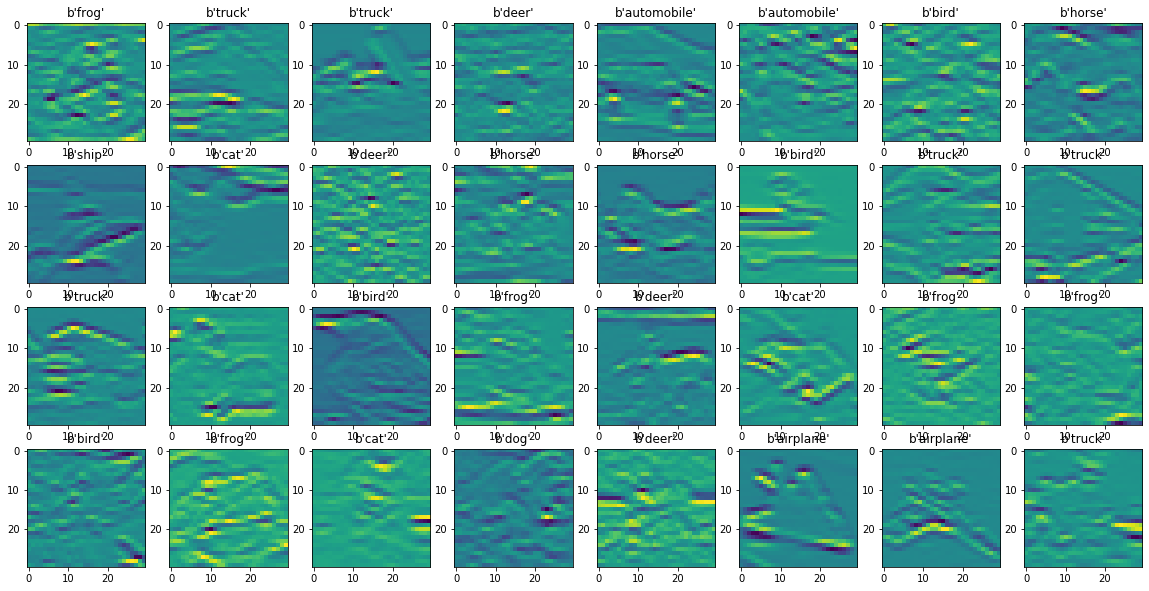

In [9]:
fig, axss = plt.subplots(4, 8, figsize=(20, 10))
for i in range(32):
    axss[i//8][i%8].set_title(cifar10["label_names"][cifar10["train_y"][i]])
    axss[i//8][i%8].imshow(simpleConv2d(cifar10["train_x"][i], hor_edge_kernel))
plt.show()

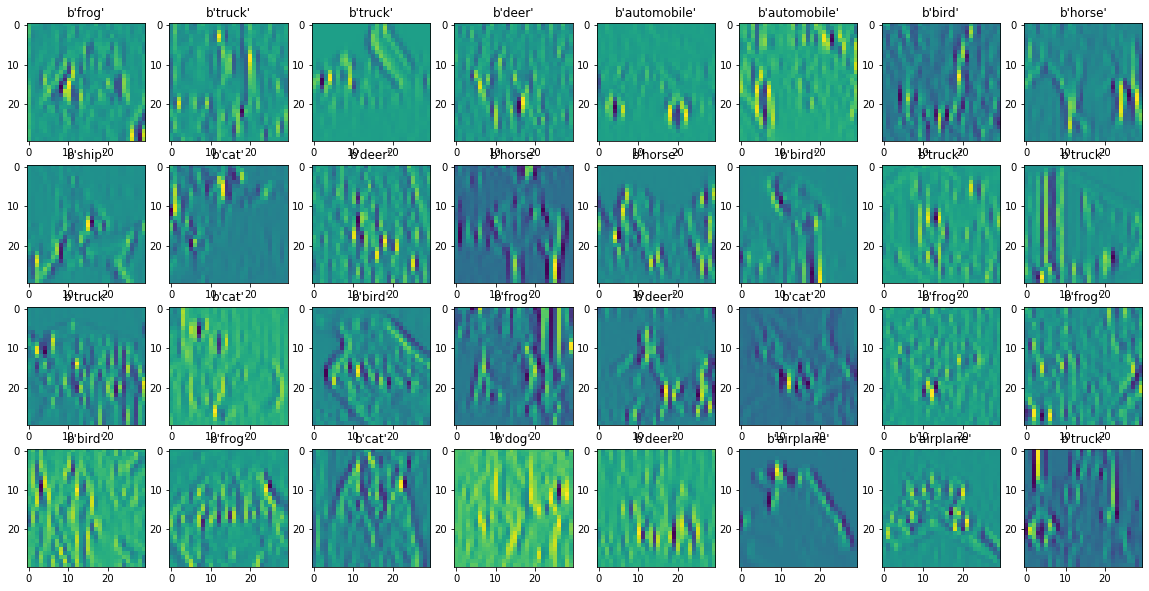

In [10]:
fig, axss = plt.subplots(4, 8, figsize=(20, 10))
for i in range(32):
    axss[i//8][i%8].set_title(cifar10["label_names"][cifar10["train_y"][i]])
    axss[i//8][i%8].imshow(simpleConv2d(cifar10["train_x"][i], ver_edge_kernel))
plt.show()

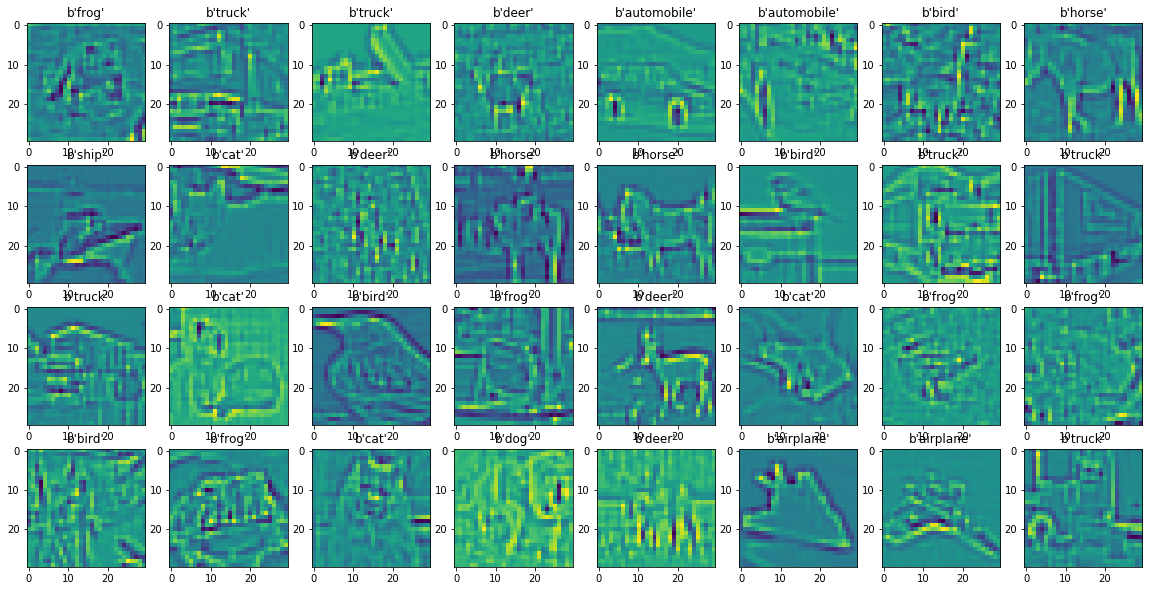

In [11]:
fig, axss = plt.subplots(4, 8, figsize=(20, 10))
for i in range(32):
    axss[i//8][i%8].set_title(cifar10["label_names"][cifar10["train_y"][i]])
    axss[i//8][i%8].imshow(simpleConv2d(cifar10["train_x"][i], horver_kernel))
plt.show()

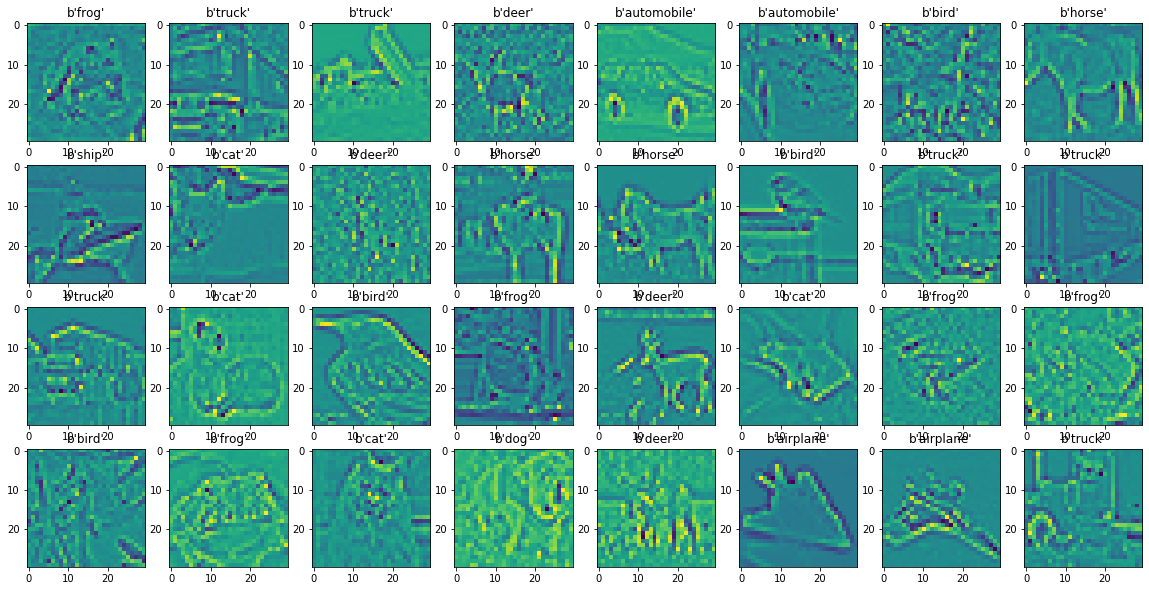

In [12]:
fig, axss = plt.subplots(4, 8, figsize=(20, 10))
for i in range(32):
    axss[i//8][i%8].set_title(cifar10["label_names"][cifar10["train_y"][i]])
    axss[i//8][i%8].imshow(simpleConv2d(cifar10["train_x"][i], lap_kernel))
plt.show()

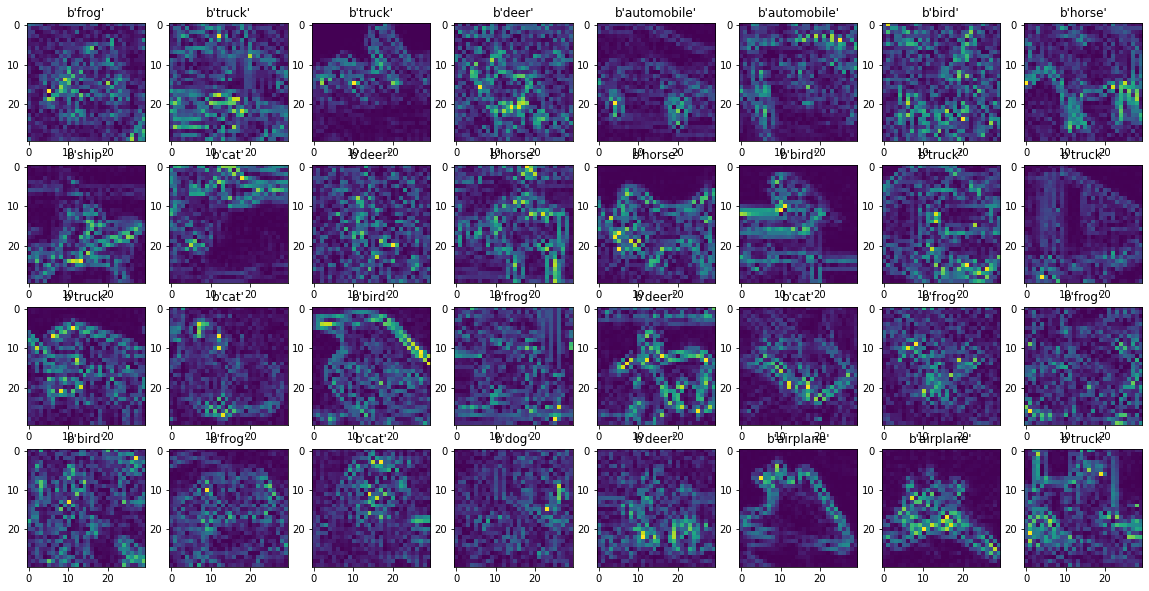

In [13]:
fig, axss = plt.subplots(4, 8, figsize=(20, 10))
for i in range(32):
    axss[i//8][i%8].set_title(cifar10["label_names"][cifar10["train_y"][i]])
    im = simpleConv2d(cifar10["train_x"][i], lap_kernel)
    axss[i//8][i%8].imshow(np.abs(im))
plt.show()

In [14]:
# CNN използват конволюции вместо dense слоеве
# Нещо което се използва често ръка за ръка с конволюциите са т.н. pooling-и
# Пример с конволюции за разпознаване на куче

In [15]:
# Да използваме за базов модел 2слойна feed forward мрежа като от предишния урок

def model_forward(x):
    x = tf.keras.layers.Dense(32, input_dim=32*32*3, activation='relu')(x)
    x = tf.keras.layers.Dense(10, input_dim=32, activation='softmax')(x)
    return x

inp = tf.keras.Input(shape=(32*32*3,))
out = model_forward(inp)
model = tf.keras.Model(inputs = inp, outputs = out)

model.compile(tf.optimizers.Adam(3e-4), loss="categorical_crossentropy", metrics=["accuracy"])
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 3072)]            0         
_________________________________________________________________
dense (Dense)                (None, 32)                98336     
_________________________________________________________________
dense_1 (Dense)              (None, 10)                330       
Total params: 98,666
Trainable params: 98,666
Non-trainable params: 0
_________________________________________________________________


In [16]:
model.fit(cifar10["train_x"].reshape(-1, 32*32*3), 
          np.eye(10)[cifar10["train_y"]], 
          batch_size=256, epochs=20, 
          validation_data=(cifar10["test_x"].reshape(-1, 32*32*3), 
                           np.eye(10)[cifar10["test_y"]]))

Train on 50000 samples, validate on 10000 samples
Epoch 1/20
50000/50000 [==============================] - 2s 49us/sample - loss: 2.0257 - accuracy: 0.2772 - val_loss: 1.9076 - val_accuracy: 0.3295
Epoch 2/20
50000/50000 [==============================] - 1s 26us/sample - loss: 1.8611 - accuracy: 0.3456 - val_loss: 1.8345 - val_accuracy: 0.3578
Epoch 3/20
50000/50000 [==============================] - 1s 26us/sample - loss: 1.8055 - accuracy: 0.3675 - val_loss: 1.7972 - val_accuracy: 0.3772
Epoch 4/20
50000/50000 [==============================] - 1s 24us/sample - loss: 1.7724 - accuracy: 0.3804 - val_loss: 1.7749 - val_accuracy: 0.3760
Epoch 5/20
50000/50000 [==============================] - 1s 24us/sample - loss: 1.7472 - accuracy: 0.3907 - val_loss: 1.7585 - val_accuracy: 0.3840
Epoch 6/20
50000/50000 [==============================] - 1s 24us/sample - loss: 1.7288 - accuracy: 0.3966 - val_loss: 1.7225 - val_accuracy: 0.4003
Epoch 7/20
50000/50000 [==============================] 

In [17]:
# Както е лесно да забележим, този dataset е по-тегав относно сложността на функцията която трябва да се научи
# Трябва ни по-дълбок модел

def model_forward(x):
    x = tf.keras.layers.Dense(64, input_dim=32*32*3, activation='relu')(x)
    x = tf.keras.layers.Dense(32, input_dim=64, activation='relu')(x)
    x = tf.keras.layers.Dense(10, input_dim=32, activation='softmax')(x)
    return x

inp = tf.keras.Input(shape=(32*32*3,))
out = model_forward(inp)
model = tf.keras.Model(inputs = inp, outputs = out)

model.compile(tf.optimizers.Adam(3e-4), loss="categorical_crossentropy", metrics=["accuracy"])
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 3072)]            0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                196672    
_________________________________________________________________
dense_3 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_4 (Dense)              (None, 10)                330       
Total params: 199,082
Trainable params: 199,082
Non-trainable params: 0
_________________________________________________________________


In [18]:
# Забележете броя на параметрите

model.fit(cifar10["train_x"].reshape(-1, 32*32*3), 
          np.eye(10)[cifar10["train_y"]], 
          batch_size=256, epochs=20, 
          validation_data=(cifar10["test_x"].reshape(-1, 32*32*3), 
                           np.eye(10)[cifar10["test_y"]]))

Train on 50000 samples, validate on 10000 samples
Epoch 1/20
50000/50000 [==============================] - 2s 31us/sample - loss: 1.9764 - accuracy: 0.2832 - val_loss: 1.8521 - val_accuracy: 0.3465
Epoch 2/20
50000/50000 [==============================] - 1s 24us/sample - loss: 1.8156 - accuracy: 0.3607 - val_loss: 1.7725 - val_accuracy: 0.3746
Epoch 3/20
50000/50000 [==============================] - 1s 24us/sample - loss: 1.7527 - accuracy: 0.3792 - val_loss: 1.7521 - val_accuracy: 0.3766
Epoch 4/20
50000/50000 [==============================] - 1s 25us/sample - loss: 1.7128 - accuracy: 0.3959 - val_loss: 1.6963 - val_accuracy: 0.3990
Epoch 5/20
50000/50000 [==============================] - 1s 26us/sample - loss: 1.6751 - accuracy: 0.4092 - val_loss: 1.6875 - val_accuracy: 0.4103
Epoch 6/20
50000/50000 [==============================] - 1s 24us/sample - loss: 1.6488 - accuracy: 0.4194 - val_loss: 1.6535 - val_accuracy: 0.4162
Epoch 7/20
50000/50000 [==============================] 

In [19]:
# Забелязваме подобрение, но започваме и да забелязваме стабилен overfit
# Това се дължи на много неща, но най-вече това че модела ни има 200к параметра, а имаме само 50к примера
# Няколко думи за борене с оувърфит в NN (dropout)

In [20]:
# Време е да обсъдим как изглежда една CNN

def model_forward(x):
    x = tf.keras.layers.Conv2D(16, (5, 5), input_shape=(32, 32, 3), activation='relu')(x)
    x = tf.keras.layers.MaxPool2D((2, 2), input_shape=(28, 28, 16))(x)
    x = tf.keras.layers.Conv2D(64, (3, 3), input_shape=(14, 14, 16), activation='relu')(x)
    x = tf.keras.layers.Conv2D(32, (3, 3), input_shape=(12, 12, 64), activation='relu')(x)
    x = tf.keras.layers.MaxPool2D((2, 2), input_shape=(10, 10, 32))(x)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(10, input_dim=5*5*32, activation='softmax')(x)
    return x

inp = tf.keras.Input(shape=(32, 32, 3))
out = model_forward(inp)
model = tf.keras.Model(inputs = inp, outputs = out)

model.compile(tf.optimizers.Adam(1e-3), loss="categorical_crossentropy", metrics=["accuracy"])
model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 28, 28, 16)        1216      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 12, 12, 64)        9280      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 10, 10, 32)        18464     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 32)          0         
_________________________________________________________________
flatten (Flatten)            (None, 800)               0   

In [21]:
model.fit(cifar10["train_x"], 
          np.eye(10)[cifar10["train_y"]], 
          batch_size=256, epochs=20, 
          validation_data=(cifar10["test_x"], 
                           np.eye(10)[cifar10["test_y"]]))

Train on 50000 samples, validate on 10000 samples
Epoch 1/20
50000/50000 [==============================] - 5s 103us/sample - loss: 1.7966 - accuracy: 0.3470 - val_loss: 1.5885 - val_accuracy: 0.4300
Epoch 2/20
50000/50000 [==============================] - 3s 52us/sample - loss: 1.4862 - accuracy: 0.4692 - val_loss: 1.4549 - val_accuracy: 0.4806
Epoch 3/20
50000/50000 [==============================] - 3s 52us/sample - loss: 1.3943 - accuracy: 0.5040 - val_loss: 1.3809 - val_accuracy: 0.5017
Epoch 4/20
50000/50000 [==============================] - 3s 57us/sample - loss: 1.3256 - accuracy: 0.5296 - val_loss: 1.3211 - val_accuracy: 0.5317
Epoch 5/20
50000/50000 [==============================] - 3s 57us/sample - loss: 1.2559 - accuracy: 0.5588 - val_loss: 1.2614 - val_accuracy: 0.5538
Epoch 6/20
50000/50000 [==============================] - 3s 54us/sample - loss: 1.2125 - accuracy: 0.5723 - val_loss: 1.2638 - val_accuracy: 0.5559
Epoch 7/20
50000/50000 [==============================]

In [22]:
from tensorflow.keras.regularizers import l2

def model_forward(x):
    x = tf.keras.layers.Conv2D(16, (5, 5), input_shape=(32, 32, 3), activation='relu', kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01))(x)
    x = tf.keras.layers.MaxPool2D((2, 2), input_shape=(28, 28, 16))(x)
    x = tf.keras.layers.Conv2D(64, (3, 3), input_shape=(14, 14, 16), activation='relu', kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01))(x)
    x = tf.keras.layers.Conv2D(32, (3, 3), input_shape=(12, 12, 64), activation='relu', kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01))(x)
    x = tf.keras.layers.MaxPool2D((2, 2), input_shape=(10, 10, 32))(x)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(10, input_dim=5*5*32, activation='softmax', kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01))(x)
    return x

inp = tf.keras.Input(shape=(32, 32, 3))
out = model_forward(inp)
model = tf.keras.Model(inputs = inp, outputs = out)

model.compile(tf.optimizers.Adam(1e-3), loss="categorical_crossentropy", metrics=["accuracy"])
model.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 28, 28, 16)        1216      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 12, 12, 64)        9280      
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 10, 10, 32)        18464     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 5, 5, 32)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 800)               0   

In [23]:
model.fit(cifar10["train_x"], 
          np.eye(10)[cifar10["train_y"]], 
          batch_size=256, epochs=20, 
          validation_data=(cifar10["test_x"], 
                           np.eye(10)[cifar10["test_y"]]))

Train on 50000 samples, validate on 10000 samples
Epoch 1/20
50000/50000 [==============================] - 3s 64us/sample - loss: 2.2101 - accuracy: 0.3025 - val_loss: 1.8718 - val_accuracy: 0.3956
Epoch 2/20
50000/50000 [==============================] - 3s 54us/sample - loss: 1.8388 - accuracy: 0.4087 - val_loss: 1.7911 - val_accuracy: 0.4219
Epoch 3/20
50000/50000 [==============================] - 3s 54us/sample - loss: 1.7498 - accuracy: 0.4417 - val_loss: 1.7547 - val_accuracy: 0.4393
Epoch 4/20
50000/50000 [==============================] - 3s 53us/sample - loss: 1.7138 - accuracy: 0.4558 - val_loss: 1.7224 - val_accuracy: 0.4515
Epoch 5/20
50000/50000 [==============================] - 3s 53us/sample - loss: 1.6793 - accuracy: 0.4695 - val_loss: 1.6692 - val_accuracy: 0.4719
Epoch 6/20
50000/50000 [==============================] - 3s 53us/sample - loss: 1.6572 - accuracy: 0.4804 - val_loss: 1.6445 - val_accuracy: 0.4834
Epoch 7/20
50000/50000 [==============================] 

In [24]:
def model_forward(x):
    x = tf.keras.layers.Conv2D(16, (5, 5), input_shape=(32, 32, 3), activation='relu')(x)
    x = tf.keras.layers.MaxPool2D((2, 2), input_shape=(28, 28, 16))(x)
    x = tf.keras.layers.Conv2D(64, (3, 3), input_shape=(14, 14, 16), activation='relu')(x)
    x = tf.keras.layers.Conv2D(32, (3, 3), input_shape=(12, 12, 64), activation='relu', kernel_regularizer=l2(1e-3), bias_regularizer=l2(0.01))(x)
    x = tf.keras.layers.MaxPool2D((2, 2), input_shape=(10, 10, 32))(x)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    x = tf.keras.layers.Dense(10, input_dim=5*5*32, activation='softmax')(x)
    return x

inp = tf.keras.Input(shape=(32, 32, 3))
out = model_forward(inp)
model = tf.keras.Model(inputs = inp, outputs = out)

model.compile(tf.optimizers.Adam(2e-3), loss="categorical_crossentropy", metrics=["accuracy"])
model.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 28, 28, 16)        1216      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 12, 12, 64)        9280      
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 10, 10, 32)        18464     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 5, 5, 32)          0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 800)               0   

In [25]:
model.fit(cifar10["train_x"], 
          np.eye(10)[cifar10["train_y"]], 
          batch_size=256, epochs=20, 
          validation_data=(cifar10["test_x"], 
                           np.eye(10)[cifar10["test_y"]]))

Train on 50000 samples, validate on 10000 samples
Epoch 1/20
50000/50000 [==============================] - 3s 63us/sample - loss: 1.7718 - accuracy: 0.3649 - val_loss: 1.5161 - val_accuracy: 0.4624
Epoch 2/20
50000/50000 [==============================] - 3s 54us/sample - loss: 1.4602 - accuracy: 0.4873 - val_loss: 1.3575 - val_accuracy: 0.5237
Epoch 3/20
50000/50000 [==============================] - 3s 53us/sample - loss: 1.3485 - accuracy: 0.5308 - val_loss: 1.3019 - val_accuracy: 0.5451
Epoch 4/20
50000/50000 [==============================] - 3s 54us/sample - loss: 1.2738 - accuracy: 0.5620 - val_loss: 1.2144 - val_accuracy: 0.5776
Epoch 5/20
50000/50000 [==============================] - 3s 54us/sample - loss: 1.2143 - accuracy: 0.5839 - val_loss: 1.1704 - val_accuracy: 0.5954
Epoch 6/20
50000/50000 [==============================] - 3s 53us/sample - loss: 1.1581 - accuracy: 0.6062 - val_loss: 1.1029 - val_accuracy: 0.6245
Epoch 7/20
50000/50000 [==============================] 

In [26]:
# Нека пробваме с по-дълбока мрежа защото така или иначе на train accuracy не се справяме особено добре

def model_forward(x):
    x = tf.keras.layers.Conv2D(16, (3, 3), input_shape=(32, 32, 3), padding='same', activation='relu')(x)
    x = tf.keras.layers.Conv2D(16, (3, 3), input_shape=(32, 32, 16), padding='same', activation='relu')(x)
    x = tf.keras.layers.MaxPool2D((2, 2), input_shape=(32, 32, 16))(x)
    x = tf.keras.layers.Conv2D(32, (3, 3), input_shape=(16, 16, 16), padding='same', activation='relu')(x)
    x = tf.keras.layers.Conv2D(32, (3, 3), input_shape=(16, 16, 32), padding='same', activation='relu')(x)
    x = tf.keras.layers.Conv2D(32, (3, 3), input_shape=(16, 16, 32), padding='same', activation='relu')(x)
    x = tf.keras.layers.Conv2D(32, (3, 3), input_shape=(16, 16, 32), padding='same', activation='relu')(x)
    x = tf.keras.layers.MaxPool2D((2, 2), input_shape=(16, 16, 32))(x)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(10, input_dim=8*8*32, activation='softmax')(x)
    return x

inp = tf.keras.Input(shape=(32, 32, 3))
out = model_forward(inp)
model = tf.keras.Model(inputs = inp, outputs = out)

model.compile(tf.optimizers.Adam(1e-3), loss="categorical_crossentropy", metrics=["accuracy"])
model.summary()

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 32, 32, 16)        448       
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 32, 32, 16)        2320      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 16, 16, 16)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 16, 16, 32)        4640      
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 16, 16, 32)        9248      
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 16, 16, 32)        9248

In [27]:
model.fit(cifar10["train_x"], 
          np.eye(10)[cifar10["train_y"]], 
          batch_size=256, epochs=20, 
          validation_data=(cifar10["test_x"], 
                           np.eye(10)[cifar10["test_y"]]))

Train on 50000 samples, validate on 10000 samples
Epoch 1/20
50000/50000 [==============================] - 5s 108us/sample - loss: 1.7169 - accuracy: 0.3749 - val_loss: 1.4851 - val_accuracy: 0.4622
Epoch 2/20
50000/50000 [==============================] - 4s 87us/sample - loss: 1.4011 - accuracy: 0.4966 - val_loss: 1.3059 - val_accuracy: 0.5360
Epoch 3/20
50000/50000 [==============================] - 4s 89us/sample - loss: 1.2260 - accuracy: 0.5643 - val_loss: 1.1666 - val_accuracy: 0.5862
Epoch 4/20
50000/50000 [==============================] - 4s 89us/sample - loss: 1.1036 - accuracy: 0.6088 - val_loss: 1.1183 - val_accuracy: 0.6019
Epoch 5/20
50000/50000 [==============================] - 4s 88us/sample - loss: 1.0197 - accuracy: 0.6434 - val_loss: 0.9964 - val_accuracy: 0.6528ss: 1.0234 - accuracy - ETA: 0s - loss: 1.0215 - accura
Epoch 6/20
50000/50000 [==============================] - 4s 89us/sample - loss: 0.9523 - accuracy: 0.6656 - val_loss: 0.9676 - val_accuracy: 0.6648u

In [28]:
# Накрая малко повечко страдаме от overfit, но с регуларизация това може да се поправи
# Предположение: колкото повече слоеве толкова по-добре?
# Отговор: ми не баш...


def model_forward(x):
    x = tf.keras.layers.Conv2D(16, (3, 3), input_shape=(32, 32, 3), padding='same', activation='relu')(x)
    x = tf.keras.layers.Conv2D(16, (3, 3), input_shape=(32, 32, 16), padding='same', activation='relu')(x)
    x = tf.keras.layers.MaxPool2D((2, 2), input_shape=(32, 32, 16))(x)
    for i in range(10):
        x = tf.keras.layers.Conv2D(32, (3, 3), padding='same', activation='relu')(x)
    x = tf.keras.layers.MaxPool2D((2, 2), input_shape=(16, 16, 32))(x)
    for i in range(10):
        x = tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu')(x)
    x = tf.keras.layers.MaxPool2D((2, 2), input_shape=(8, 8, 64))(x)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(10, input_dim=4*4*64, activation='softmax')(x)
    return x

inp = tf.keras.Input(shape=(32, 32, 3))
out = model_forward(inp)
model = tf.keras.Model(inputs = inp, outputs = out)

model.compile(tf.optimizers.Adam(1e-4), loss="categorical_crossentropy", metrics=["accuracy"])
model.summary()

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 32, 32, 16)        448       
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 32, 32, 16)        2320      
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 16, 16, 16)        0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 16, 16, 32)        4640      
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 16, 16, 32)        9248      
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 16, 16, 32)        9248

In [29]:
model.fit(cifar10["train_x"], 
          np.eye(10)[cifar10["train_y"]], 
          batch_size=256, epochs=5, 
          validation_data=(cifar10["test_x"], 
                           np.eye(10)[cifar10["test_y"]]))

Train on 50000 samples, validate on 10000 samples
Epoch 1/5
50000/50000 [==============================] - 11s 227us/sample - loss: 2.1226 - accuracy: 0.1747 - val_loss: 1.9128 - val_accuracy: 0.2259
Epoch 2/5
50000/50000 [==============================] - 10s 201us/sample - loss: 1.8923 - accuracy: 0.2557 - val_loss: 1.8373 - val_accuracy: 0.2857
Epoch 3/5
50000/50000 [==============================] - 10s 201us/sample - loss: 1.8063 - accuracy: 0.3021 - val_loss: 1.7416 - val_accuracy: 0.3412
Epoch 4/5
50000/50000 [==============================] - 10s 203us/sample - loss: 1.6939 - accuracy: 0.3607 - val_loss: 1.6144 - val_accuracy: 0.3961
Epoch 5/5
50000/50000 [==============================] - 10s 203us/sample - loss: 1.5744 - accuracy: 0.4133 - val_loss: 1.5261 - val_accuracy: 0.4234


In [30]:
# Не го пуснах за много епохи, щото самото трениране е по-бавно
# Може да забележим че прогреса за 5 епохи е много по-малък от колкото на другия модел
# Този проблем се влошава с дълбочината и в един момент модела става нетренируем...
# Да обсъдим защо... Решения?

In [31]:
# На помощ идва ResNet!
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, Add, MaxPooling2D, Input, UpSampling2D, Lambda, Cropping2D


def conv(ch, kernel, stride=(1, 1), padding='same'):
    def f(y):
        y = BatchNormalization()(y)
        y = Activation('relu')(y)
        y = Conv2D(ch, kernel, strides=stride, padding=padding)(y)
        return y
    return f

def residual(ch, kernel=(3, 3), first_stride=(2, 2), second_stride=(1, 1), hasChange=False):
    def f(y):
        shortcut = y
        y = conv(ch, kernel, first_stride)(y)
        y = conv(ch, kernel, second_stride)(y)
        if hasChange: shortcut = Conv2D(ch, (1, 1), strides=first_stride, padding='same')(shortcut)
        y = Add()([shortcut, y])
        return y
    return f

def resnet18(x):
    
    x = Conv2D(16, (7, 7), strides=(2, 2), padding='same')(x)
    
    x = residual(16, first_stride=(1, 1))(x)
    x = residual(16, first_stride=(1, 1))(x)
    
    x = residual(32, hasChange=True)(x)
    x = residual(32, first_stride=(1, 1))(x)
    
    x = residual(32, first_stride=(1, 1), hasChange=True)(x)
    x = residual(32, first_stride=(1, 1))(x)
    
    x = residual(64, first_stride=(1, 1), hasChange=True)(x)
    x = residual(64, first_stride=(1, 1))(x)
    
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(10, activation='softmax')(x)
    
    return x

inp = tf.keras.Input(shape=(32, 32, 3))
out = resnet18(inp)
model = tf.keras.Model(inputs = inp, outputs = out)

model.compile(tf.optimizers.Adam(3e-4), loss="categorical_crossentropy", metrics=["accuracy"])
model.summary()

Model: "model_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_37 (Conv2D)              (None, 16, 16, 16)   2368        input_8[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 16, 16, 16)   64          conv2d_37[0][0]                  
__________________________________________________________________________________________________
activation (Activation)         (None, 16, 16, 16)   0           batch_normalization[0][0]        
____________________________________________________________________________________________

In [33]:
model.fit(cifar10["train_x"], 
          np.eye(10)[cifar10["train_y"]], 
          batch_size=256, epochs=20, 
          validation_data=(cifar10["test_x"], 
                           np.eye(10)[cifar10["test_y"]]))

Train on 50000 samples, validate on 10000 samples
Epoch 1/20
50000/50000 [==============================] - 7s 135us/sample - loss: 0.5525 - accuracy: 0.8139 - val_loss: 1.5530 - val_accuracy: 0.5454
Epoch 2/20
50000/50000 [==============================] - 7s 133us/sample - loss: 0.4733 - accuracy: 0.8468 - val_loss: 1.6063 - val_accuracy: 0.5304
Epoch 3/20
50000/50000 [==============================] - 7s 131us/sample - loss: 0.4107 - accuracy: 0.8671 - val_loss: 1.6980 - val_accuracy: 0.5249oss: 0 - ETA - ETA: 2s - loss: 0.3957 - accuracy - ETA: 1s - loss: - ETA: 0s
Epoch 4/20
50000/50000 [==============================] - 7s 134us/sample - loss: 0.3449 - accuracy: 0.8918 - val_loss: 1.7170 - val_accuracy: 0.5416
Epoch 5/20
50000/50000 [==============================] - 7s 132us/sample - loss: 0.2878 - accuracy: 0.9126 - val_loss: 1.8163 - val_accuracy: 0.5326
Epoch 6/20
50000/50000 [==============================] - 7s 133us/sample - loss: 0.2357 - accuracy: 0.9315 - val_loss: 1.96